In [1]:
import torch,torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import pandas as pd
import wandb
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from tqdm import tqdm
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
PROJECT_NAME = 'Car-Object-Detection-V9-Learning-Detectron2-V2'

In [2]:
data = pd.read_csv('./data.csv')

In [4]:
info = data.iloc[0]

In [6]:
img = cv2.imread(f'./data/{info["image"]}')
xmin = info['xmin']
ymin = info['ymin']
xmax = info['xmax']
ymax = info['ymax']

In [14]:
xmin,ymin,xmax,ymax

(281.2590449, 187.0350708, 327.7279305, 223.225547)

In [15]:
x = round(xmin)
y = round(ymin)
w = round(xmax - xmin)
h = round(ymax - ymin)

In [16]:
x,y,w,h

(281, 187, 46, 36)

In [17]:
crop = img[y:y+h,x:x+w]

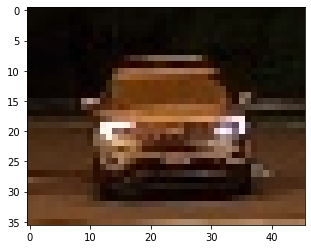

In [18]:
plt.imshow(crop)

In [20]:
cv2.imwrite('./crop.png',crop)

True

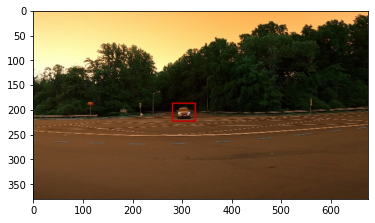

In [21]:
plt.imshow(cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2))

In [22]:
cv2.imwrite('./box.png',cv2.rectangle(img,(x,y),(x+w,y+h),(200,0,0),2))

True

In [23]:
def load_data():
    if 'data.npy' in os.listdir('./'):
        return np.load('data.npy',allow_pickle=True)
    records = []
    for i in tqdm(range(len(data))):
        info = data.iloc[i]
        record = {}
        record['height'],record['width'] = cv2.imread(f'./data/{info["image"]}').shape[:2]
        record['file_name'] = f'./data/{info["image"]}'
        record['image_id'] = i
        record['annotations'] = [
            {
                'bbox':[info['xmin'],info['ymin'],info['xmax'],info['ymax']],
                'bbox_mode':BoxMode.XYXY_ABS,
                'category_id':0
            }
        ]
        records.append(record)
    np.save('./data.npy',records)
    return records

In [24]:
labels = ['Car']

In [25]:
DatasetCatalog.register('data',lambda : load_data())
MetadataCatalog.get('data').set(thing_classes=labels)
metadata = MetadataCatalog.get('data')

In [26]:
model = "COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"

In [27]:
wandb.init(project=PROJECT_NAME,name='baseline')
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model))
cfg.DATASETS.TRAIN = ('data')
cfg.DATASETS.TEST = ()
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = []
cfg.SOLVER.MAX_ITER = 1250
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(labels)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator('data',output_dir='./output/')
val_loader = build_detection_test_loader(cfg,'data')
metrics = inference_on_dataset(predictor.model,val_loader,evaluator)
wandb.log(metrics)
wandb.finish()

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-10-23 19:02:43.025392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


[10/23 19:02:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|                                                   | 0/559 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
torch.save(cfg,'cfg.pt')
torch.save(cfg,'cfg.pth')
torch.save(predictor,'predictor.pt')
torch.save(predictor,'predictor.pth')
torch.save(evaluator,'evaluator.pt')
torch.save(evaluator,'evaluator.pth')
torch.save(v,'img.pt')
torch.save(v,'img.pth')
torch.save(model,'model.pt')
torch.save(model,'model.pth')
torch.save(labels,'labels.pt')
torch.save(labels,'labels.pth')
torch.save(metrics,'metrics.pt')
torch.save(metrics,'metrics.pth')